
# Cross-correlation at USArray

This example shows how to calculate the cross-correlation functions from five
sensors of the USArray network stacked over two months from January 1, 2006 to
March 1, 2006. 

At first, we made sure to download and provide an example of the USArray data
and inventory. If for any reason, the data is not available under the ``data``
folder under the root of the repository, or if you would like to run this
script outside of the repository, the data will be automatically downloaded
with the :func:`covseisnet.data.download_usarray_data` function (see in the
second cell of this notebook).

Note that the sampling rate of these traces is voluntarily low to reduce the
size of the example data and the speed of the calculations. The data is
downsampled at 0.2 Hz.


In [1]:
from os import path


import matplotlib.pyplot as plt
import numpy as np

import covseisnet as csn

## Read and pre-process stream

We first read the example stream and pre-process it. At first, we simply
detrend and high-pass filter the data. Because the USArray data is not
synchronized at these stations, especially in 2006, we synchronize the
stream using the method
:meth:`~covseisnet.stream.NetworkStream.synchronize`. This method is
automatic and can be used in a custom way. We then normalize the traces for
cross-correlation in the time domain.



In [2]:
# Path to the example stream
FILEPATH_WAVEFORMS = "data/usarray_example.mseed"
FILEPATH_INVENTORY = "data/usarray_example.xml"

# Download the data if does not exist
if not path.exists(FILEPATH_WAVEFORMS) or not path.exists(FILEPATH_INVENTORY):
    csn.data.download_usarray_data()

# Read example stream
stream = csn.read(FILEPATH_WAVEFORMS)

# Pre-process stream
stream.detrend("linear")
stream.filter("highpass", freq=0.001)
stream.synchronize()
stream.time_normalize(method="smooth", smooth_length=101)

## Assign coordinates to the stream

We finally assign the coordinates to the stream using the method
:meth:`~covseisnet.stream.NetworkStream.assign_coordinates`. This method
requires the path to the inventory file of the network. If you do not have
the inventory file, you can download it with the method
:func:`~covseisnet.stream.NetworkStream.download_coordinates`. These methods
deal directly with the :class:`~obspy.core.inventory.Inventory` object of
the traces within the stream. Thanks to a lot of useful methods therein, we
can easily plot the inventory on a map and perform other selection tasks.



/opt/hostedtoolcache/Python/3.12.8/x64/lib/python3.12/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


/opt/hostedtoolcache/Python/3.12.8/x64/lib/python3.12/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


/opt/hostedtoolcache/Python/3.12.8/x64/lib/python3.12/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


/opt/hostedtoolcache/Python/3.12.8/x64/lib/python3.12/site-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


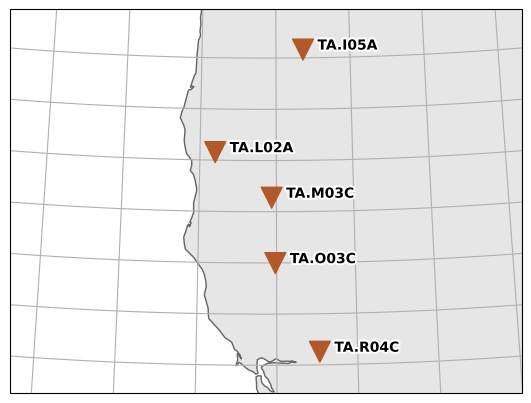

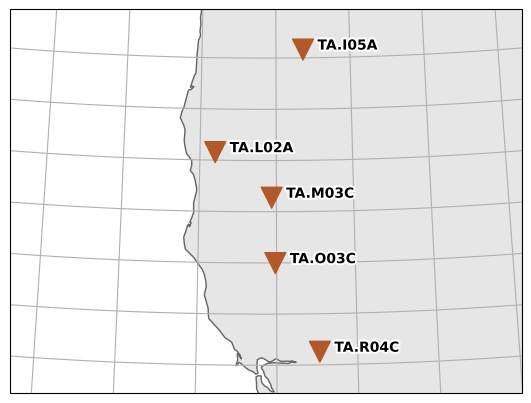

In [3]:
# Assign coordinates to the stream
stream.assign_coordinates(FILEPATH_INVENTORY)

# Plot inventory
stream.inventory.plot(projection="local", resolution="i")

## Covariance matrix

The covariance matrix is calculated using the method
:func:`~covseisnet.covariance.calculate_covariance_matrix`. The method
returns the times, frequencies, and covariances of the covariance matrix.
Among the parameters of the method, the window duration and the number of
windows are important to consider. The window duration is the length of the
Fourier estimation window in seconds, and the number of windows is the
number of windows to average to estimate the covariance matrix.

We can then visualize the covariance matrix at a given time and frequency,
and its corresponding eigenvalues.



In [4]:
# Calculate covariance matrix
times, frequencies, covariances = csn.calculate_covariance_matrix(
    stream, window_duration=800, average=500, whiten="window"
)

## Spectral width

We here extract the coherence from the covariance matrix. The coherence is
calculated using the method
:func:`~covseisnet.covariance.CovarianceMatrix.coherence`. It can either
measure the spectral width of the eigenvalue distribution at each frequency,
or with applying the formula of the Neumann entropy.



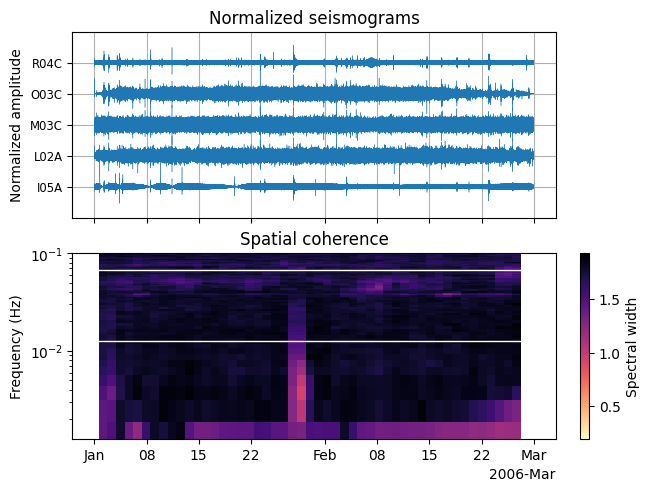

In [5]:
frequency_band = 1 / 80, 1 / 15

# Calculate coherence
coherence = covariances.coherence(kind="spectral_width")

# Show
_, ax = csn.plot.stream_and_coherence(
    stream, times, frequencies, coherence, trace_factor=0.1
)

# Indicate frequency band
ax[1].axhspan(*frequency_band, facecolor="none", edgecolor="w", clip_on=False)

## Cross-correlation

The cross-correlation matrix is calculated using the method
:func:`~covseisnet.correlation.calculate_cross_correlation_matrix`. The
method returns the lags, pairs names, and cross-correlation functions
calculated from the inverse Fourier transform of the covariance matrix. The
method requires the covariance matrix as input.

We can then visualize the cross-correlation functions between the sensors as
a function of the lag time and the distance between the sensors. Since we
selected a frequency band where no clear localized source is observed in the
covariance matrix spectral width, we can assume that the cross-correlation
functions are symmetric as we observe in the plot. We indicate the speed of
Rayleigh waves at 3.2 km/s with dashed lines.



Text(0, 0.5, 'Pairwise distance (km)')

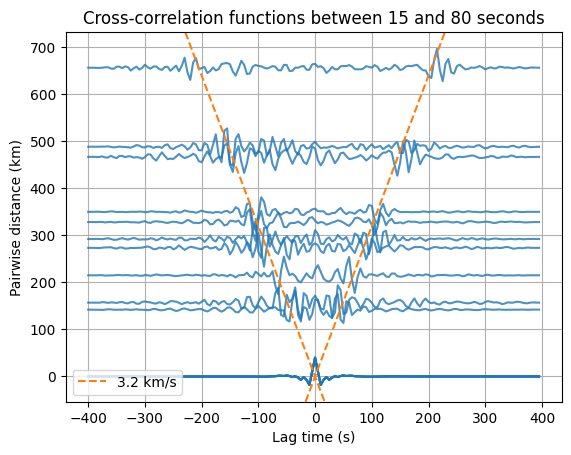

In [6]:
# Calculate cross-correlation
lags, pairs, cross_correlation = csn.calculate_cross_correlation_matrix(
    covariances
)

# Get inter-station distance
distances = csn.pairwise_great_circle_distances_from_stats(
    cross_correlation.stats
)

# Bandpass filter
cross_correlation = cross_correlation.mean(axis=1)
cross_correlation = cross_correlation.bandpass(frequency_band)
cross_correlation = cross_correlation.taper()

# Plot
fig, ax = plt.subplots()
for i_pair, pair in enumerate(pairs):
    cc = cross_correlation[i_pair] / abs(cross_correlation[i_pair]).max() * 40
    ax.plot(lags, cc + distances[i_pair], color="C0", alpha=0.8)

# Plot some velocity
v = 3.2
ax.axline((0, 0), slope=v, color="C1", label=f"{v} km/s", ls="--")
ax.axline((0, 0), slope=-v, color="C1", ls="--")

ax.legend(loc="lower left")
ax.grid()
periods = list(sorted(int(1 / f) for f in frequency_band))
ax.set_title(
    f"Cross-correlation functions between {periods[0]} and {periods[1]} seconds"
)
ax.set_xlabel("Lag time (s)")
ax.set_ylabel("Pairwise distance (km)")